#  **Bike Demand Prediction with LSTMs using TensorFlow and Keras **


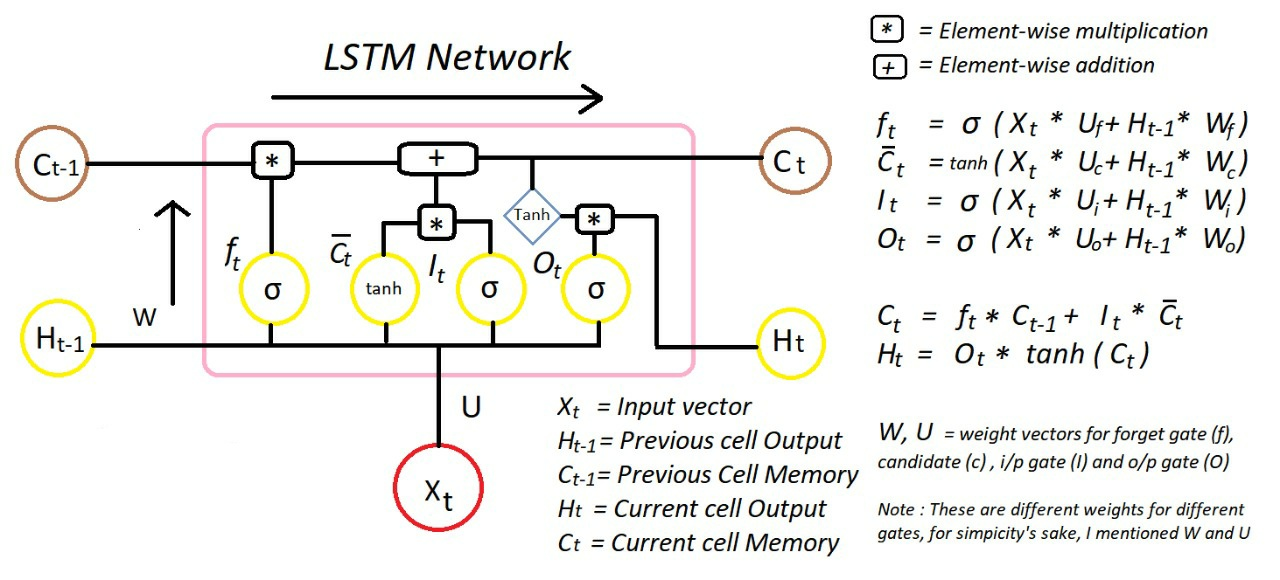

# **Bidirectional LSTM :** 
Using Bidirectional LSTMs, we feed the learning algorithm with the original data once from beginning to the end and once from end to beginning.

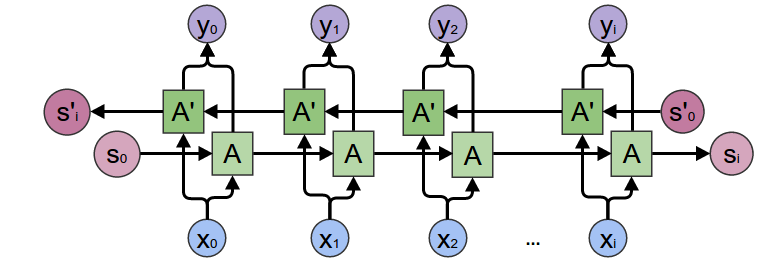


# **Goal:**
* ***Our goal is to predict the number of future bike shares given the historical data of London bike shares.***

# **Here are the steps:**
* <a href='#Data'>Data</a>
* <a href='#Feature Engineering'>Feature Engineering</a>
* <a href='#Exploratory Data Analysis'>Exploratory Data Analysis</a>
* <a href='#Preprocessing'>Preprocessing</a>
* <a href='#Model Building'>Model Building</a>
* <a href='#Demand Predictions'>Demand Predictions</a>
* <a href='#Evaluation'>Evaluation</a>

<a id='Data'></a>
# **Data**

Metadata:
* "timestamp" - timestamp field for grouping the data
* "cnt" - the count of a new bike shares
* "t1" - real temperature in C
* "t2" - temperature in C "feels like"
* "hum" - humidity in percentage
* "windspeed" - wind speed in km/h
* "weathercode" - category of the weather
* "isholiday" - boolean field - 1 holiday / 0 non holiday
* "isweekend" - boolean field - 1 if the day is weekend
* "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter
* "weathe_code" category description:
* 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
data = pd.read_csv("../input/london-bike-sharing-dataset/london_merged.csv")

In [3]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


# **GPU**

In [4]:
import tensorflow.compat.v1 as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


<a id='Feature Engineering'></a>
# **Feature Engineering**

In [5]:
import pandas as pd
import numpy as np

data.shape
data.info(memory_usage="deep")

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1, color_codes=True)

data.columns
data.head()

data["timestamp"] = pd.to_datetime(data["timestamp"])

data = data.set_index("timestamp")

data["hour"] = data.index.hour
data["day_of_month"] = data.index.day
data["day_of_week"]  = data.index.dayofweek
data["month"] = data.index.month

data.columns
data.shape

corr_matrix = data.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.5 MB


In [6]:
print(high_corr_var)

[('t1', 't2')]


In [7]:
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


<a id='Exploratory Data Analysis'></a>
# **Exploratory Data Analysis**

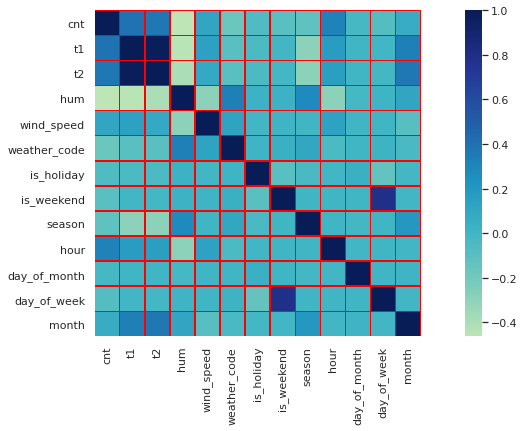

In [8]:
plt.figure(figsize=(16,6))
sns.heatmap(data.corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0,linecolor="red")

From the above heatmap we can say that **t1** and **t2** are Highly Correlated with each other.

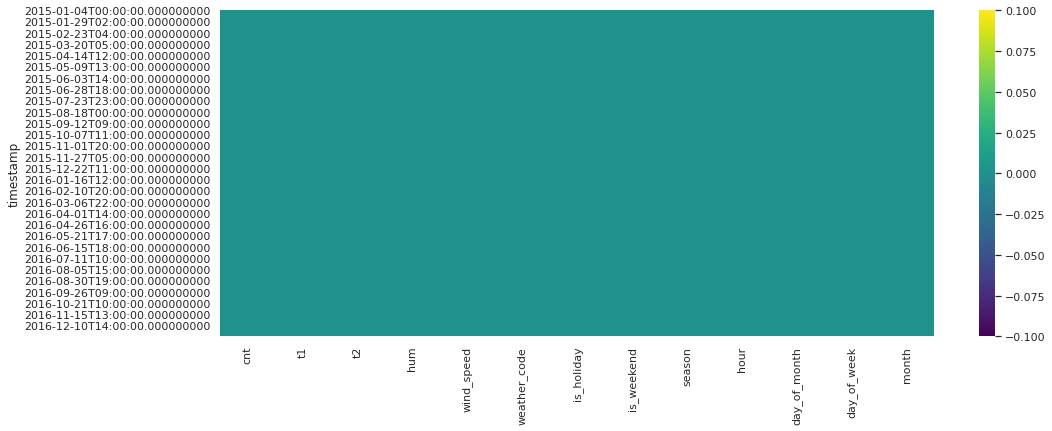

In [9]:
plt.figure(figsize=(16,6))
data.isnull().sum()
sns.heatmap(data.isnull(),cmap="viridis")

**This clean heatmap says that data does not have even a single Null value.**

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]),
 <a list of 9 Text major ticklabel objects>)

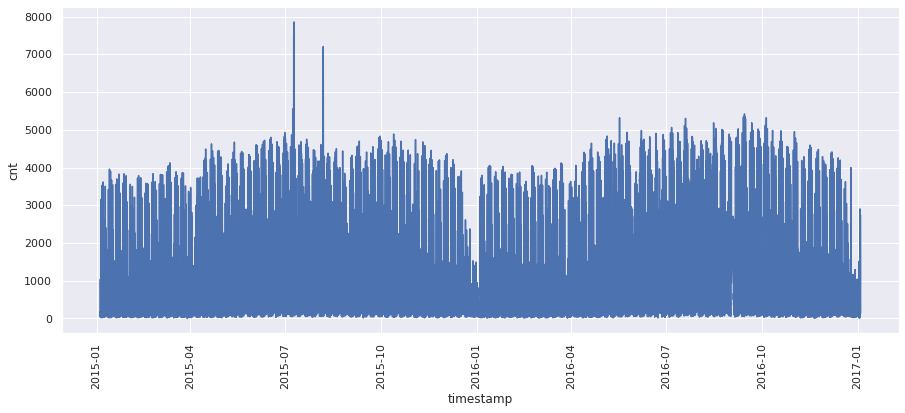

In [10]:
plt.figure(figsize=(15,6))
sns.lineplot(data=data,x=data.index,y=data.cnt)
plt.xticks(rotation=90)

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]),
 <a list of 9 Text major ticklabel objects>)

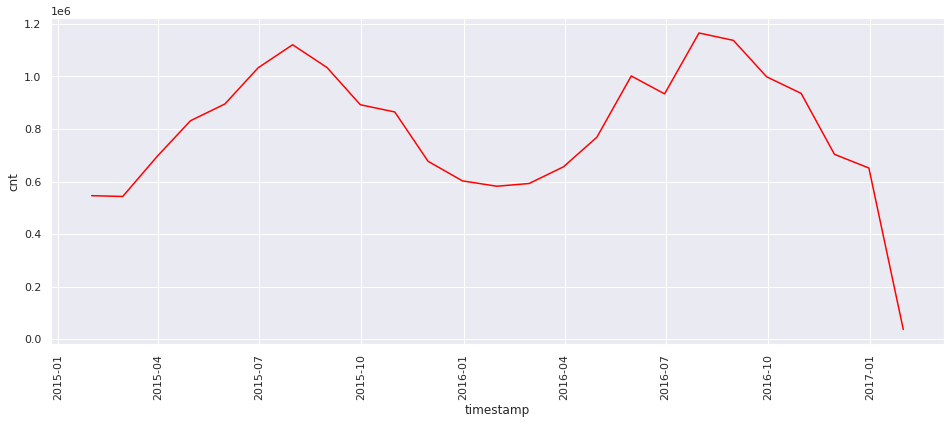

In [11]:
df_by_month = data.resample("M").sum()

plt.figure(figsize=(16,6))
sns.lineplot(data=df_by_month,x=df_by_month.index,y=df_by_month.cnt,color="red")
plt.xticks(rotation=90)

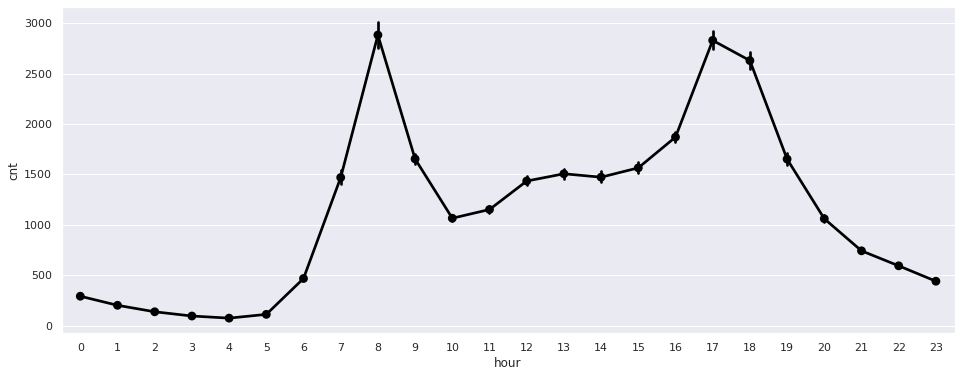

In [12]:
plt.figure(figsize=(16,6))
sns.pointplot(data=data,x=data.hour,y=data.cnt,color="black")

**Here we can say that between morning 8 to 9 the Demand is on peak.**

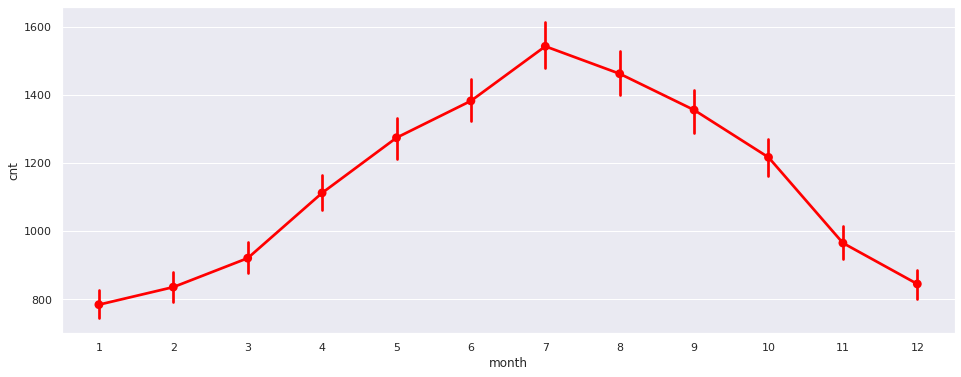

In [13]:
plt.figure(figsize=(16,6))
sns.pointplot(data=data,x=data.month,y=data.cnt,color="red")

**By looking at the above graph we can say that in the July month the demand is on peak and then start to decrease.**

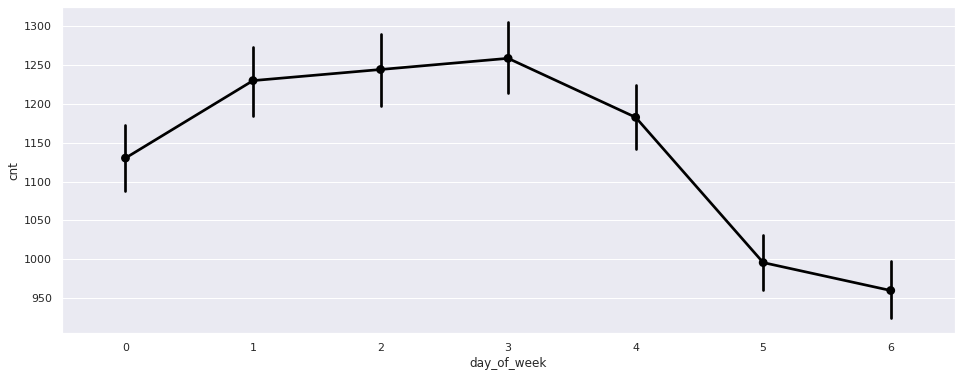

In [14]:
plt.figure(figsize=(16,6))
sns.pointplot(data=data,x=data.day_of_week,y=data.cnt,color="black")

**Least demand comes from weekend.**

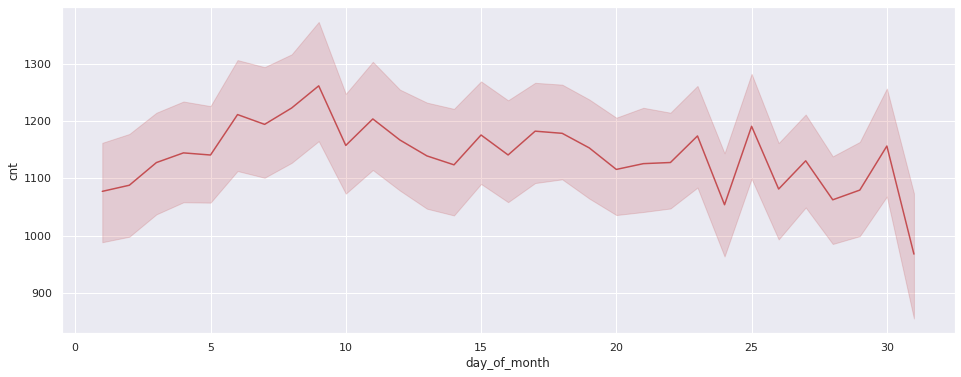

In [15]:
plt.figure(figsize=(16,6))
sns.lineplot(data=data,x=data.day_of_month,y=data.cnt,color="r")

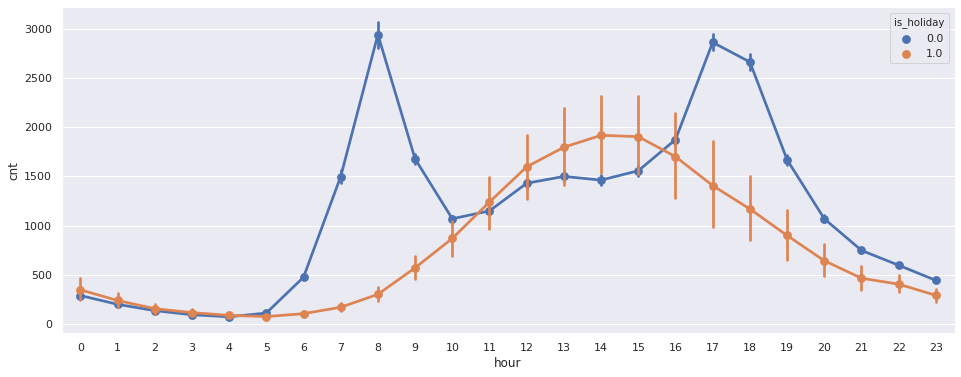

In [16]:
plt.figure(figsize=(16,6))
sns.pointplot(data=data,x=data.hour,y=data.cnt,hue=data.is_holiday)

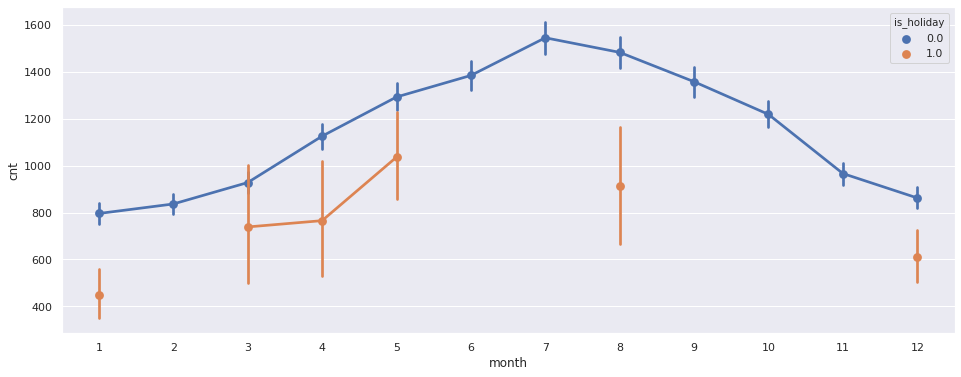

In [17]:
plt.figure(figsize=(16,6))
sns.pointplot(data=data,x=data.month,y=data.cnt,hue=data.is_holiday)

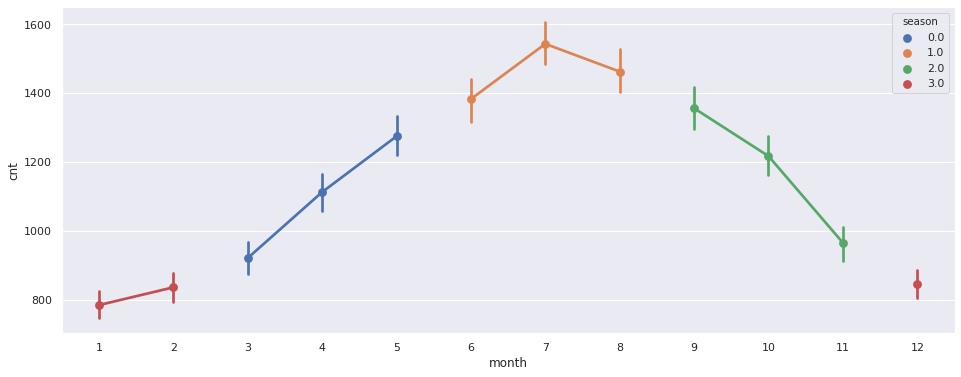

In [18]:
plt.figure(figsize=(16,6))
sns.pointplot(data=data,hue=data.season,y=data.cnt,x=data.month)

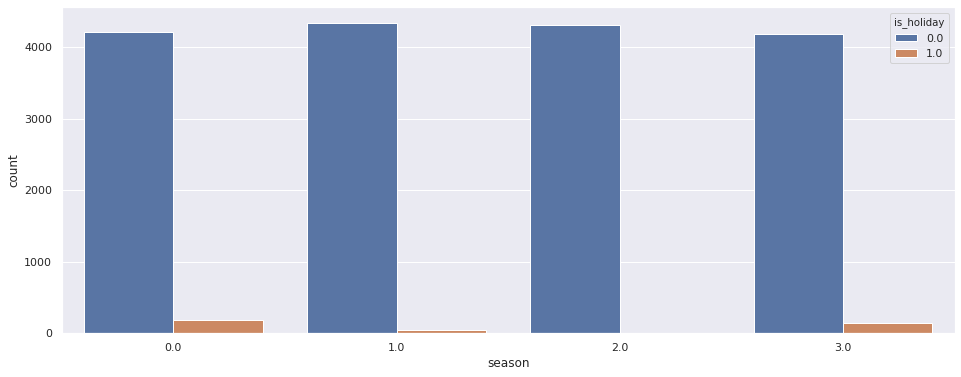

In [19]:
plt.figure(figsize=(16,6))
sns.countplot(data=data,hue=data.is_holiday,x=data.season)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]),
 <a list of 143 Text major ticklabel objects>)

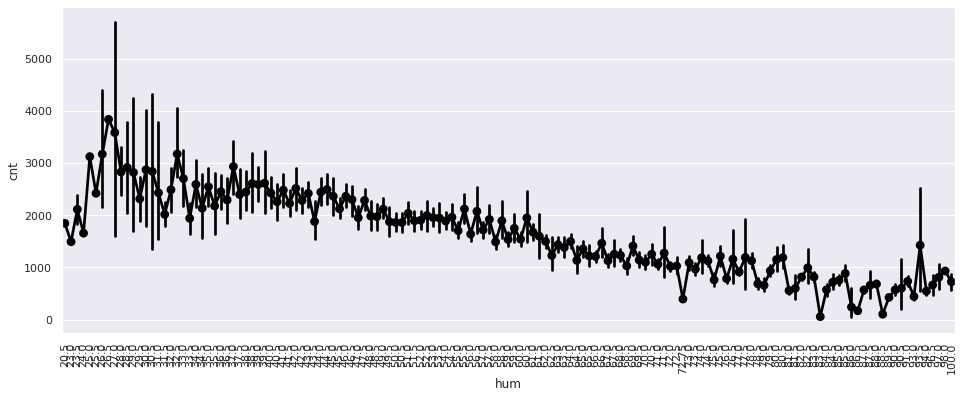

In [20]:
plt.figure(figsize=(16,6))
sns.pointplot(data=data,x=data.hum,y=data.cnt,color="black")
plt.xticks(rotation=90)

**Demand decreases with Increasing humidity.** 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102]),
 <a list of 103 Text major ticklabel objects>)

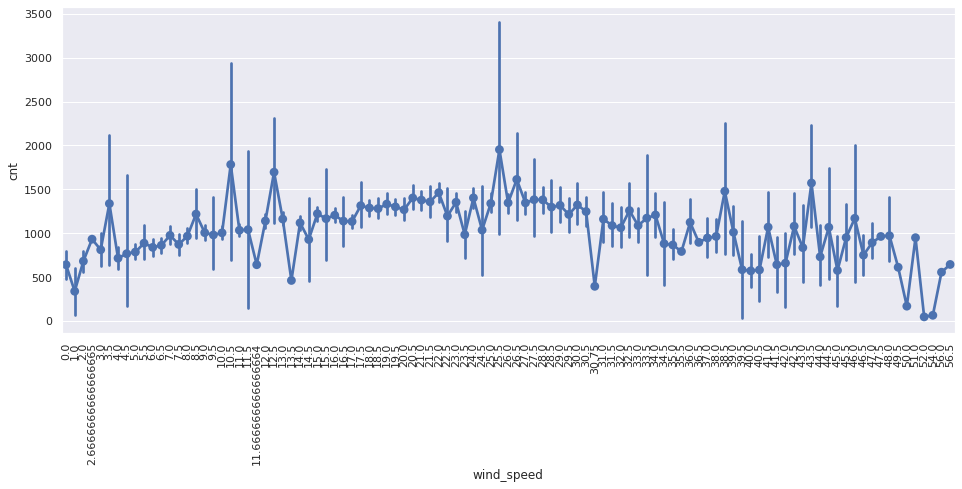

In [21]:
plt.figure(figsize=(16,6))
sns.pointplot(data=data,x=data.wind_speed,y=data.cnt)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

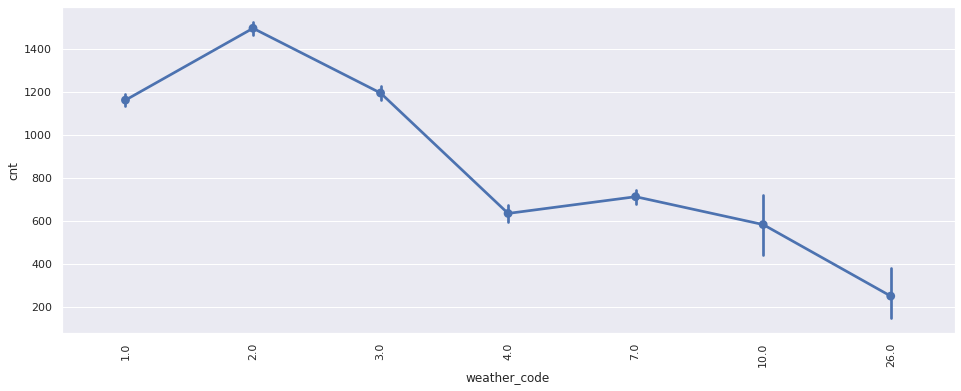

In [22]:
plt.figure(figsize=(16,6))
sns.pointplot(data=data,x=data.weather_code,y=data.cnt)
plt.xticks(rotation=90)

**Maximul demands comes in scattered coluds weather.**

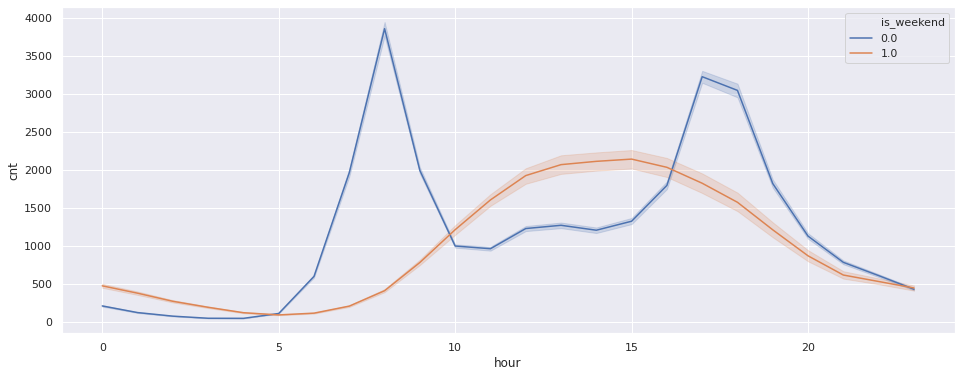

In [23]:
plt.figure(figsize=(16,6))
sns.lineplot(x=data.hour,y=data.cnt,data=data,hue=data.is_weekend)

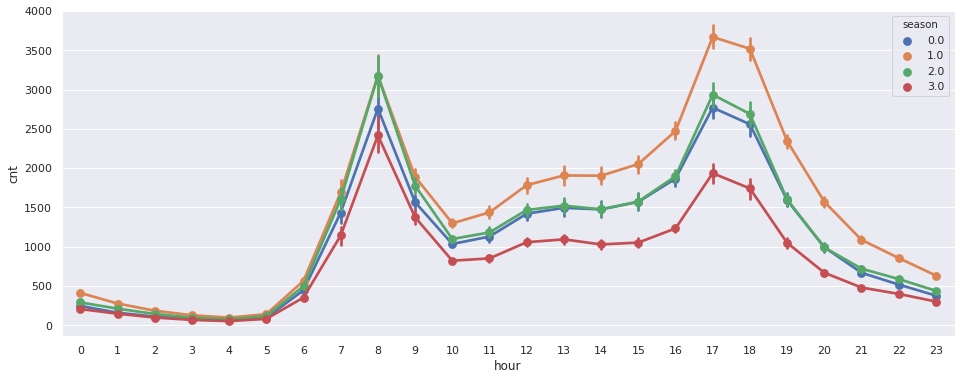

In [24]:
plt.figure(figsize=(16,6))
sns.pointplot(x=data.hour,y=data.cnt,data=data,hue=data.season)

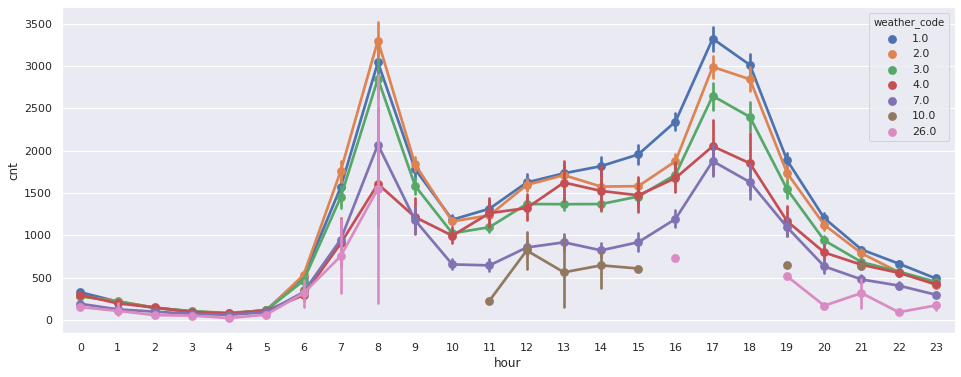

In [25]:
plt.figure(figsize=(16,6))
sns.pointplot(x=data.hour,y=data.cnt,data=data,hue=data.weather_code)

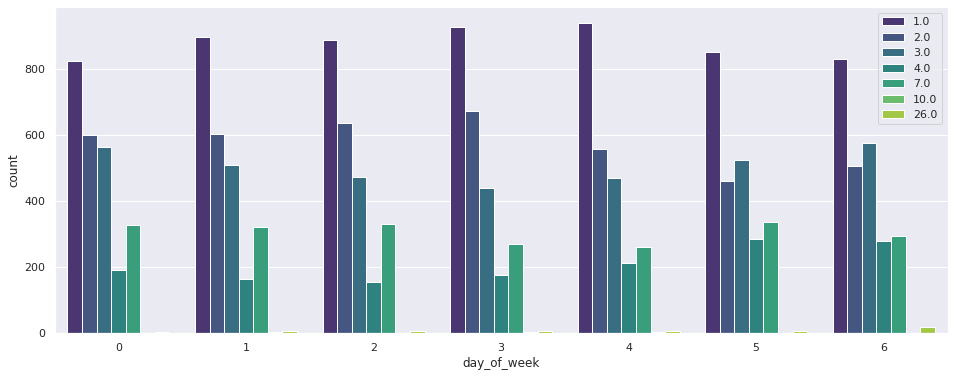

In [26]:
plt.figure(figsize=(16,6))
sns.countplot(data=data,x=data.day_of_week,hue=data.weather_code,palette="viridis")
plt.legend(loc="best")

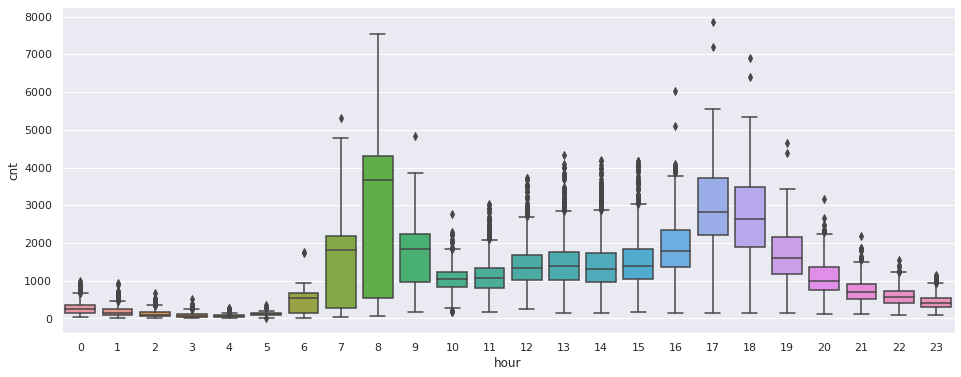

In [27]:
plt.figure(figsize=(16,6))
sns.boxplot(data=data,x=data["hour"],y=data.cnt)

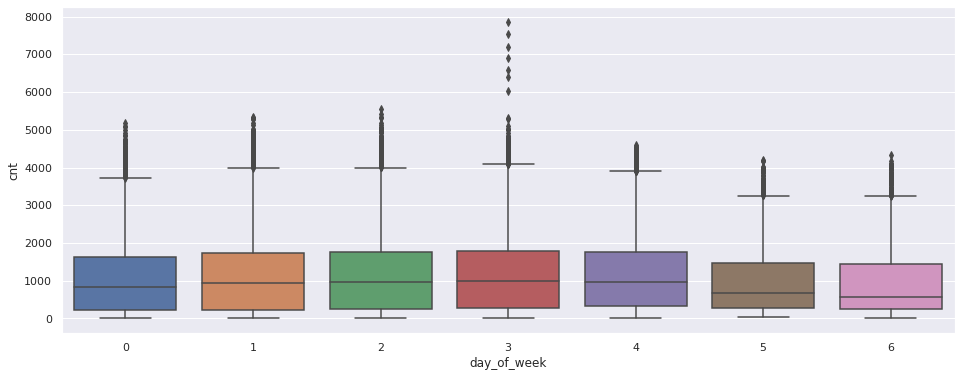

In [28]:
plt.figure(figsize=(16,6))
sns.boxplot(data=data,x=data["day_of_week"],y=data.cnt)

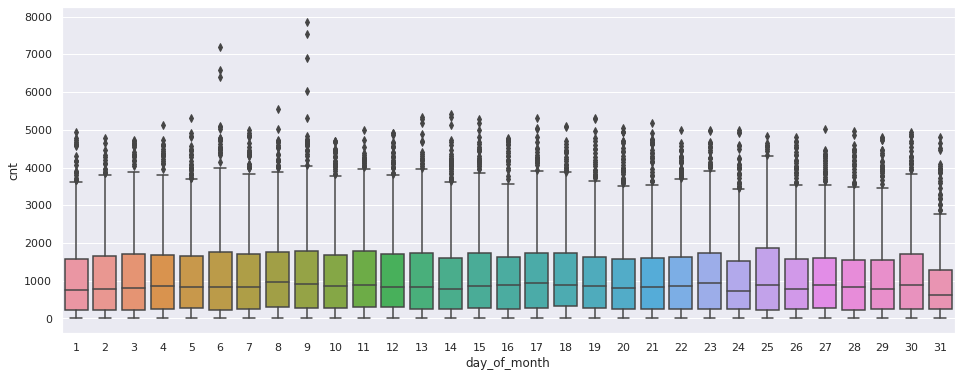

In [29]:
plt.figure(figsize=(16,6))
sns.boxplot(data=data,x=data["day_of_month"],y=data.cnt)

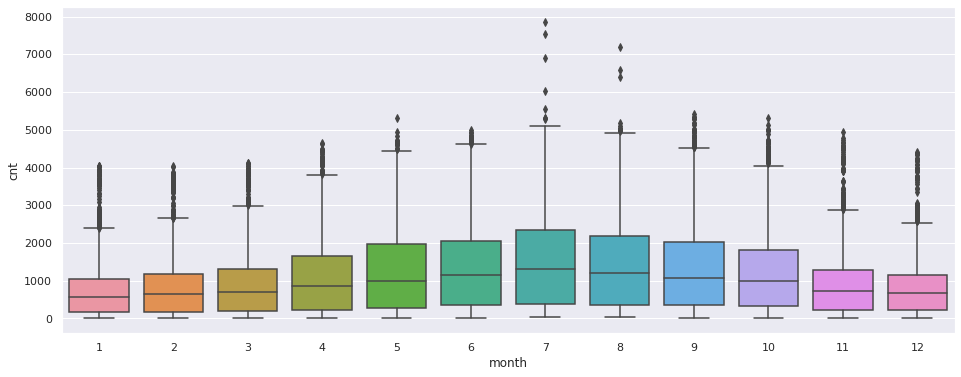

In [30]:
plt.figure(figsize=(16,6))
sns.boxplot(data=data,x=data["month"],y=data.cnt)

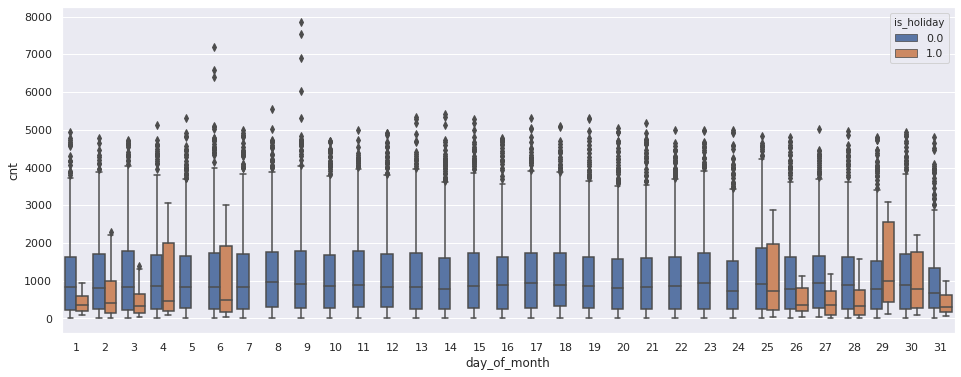

In [31]:
plt.figure(figsize=(16,6))
sns.boxplot(data=data,x=data["day_of_month"],y=data.cnt,hue=data["is_holiday"])

<a id='Preprocessing'></a>
# **Preprocessing**

* Training set = 90% of tha data
* Testing set  = 10% of the data

In [32]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size=0.1,random_state=0)

print(train.shape)
print(test.shape)


(15672, 13)
(1742, 13)


In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()

num_colu = ['t1', 't2', 'hum', 'wind_speed']
trans_1 = scaler.fit(train[num_colu].to_numpy())
train.loc[:,num_colu] = trans_1.transform(train[num_colu].to_numpy())
test.loc[:,num_colu] = trans_1.transform(test[num_colu].to_numpy())

cnt_scaler = MinMaxScaler()
trans_2 = cnt_scaler.fit(train[["cnt"]])
train["cnt"] = trans_2.transform(train[["cnt"]])
test["cnt"] = trans_2.transform(test[["cnt"]])

In [34]:
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
def prepare_data(X,y,time_steps=1):
    Xs = []
    Ys = []
    for i in tqdm(range(len(X) - time_steps)):
        a = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(a)
        Ys.append(y.iloc[i+time_steps])
    return np.array(Xs),np.array(Ys)    

steps=24
X_train , y_train = prepare_data(train,train.cnt,time_steps=steps)
X_test , y_test = prepare_data(test,test.cnt,time_steps=steps)
print("X_train : {}\nX_test : {}\ny_train : {}\ny_test: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))


X_train : (15648, 24, 13)
X_test : (1718, 24, 13)
y_train : (15648,)
y_test: (1718,)


<a id='Model Building'></a>
# **Model Building**

In [35]:
### LSTMM model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 


model = Sequential()
model.add(Bidirectional(LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="mse")

with tf.device('/GPU:0'):
    prepared_model = model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=[X_test,y_test])

plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

Using TensorFlow backend.


Train on 15648 samples, validate on 1718 samples
Epoch 1/100
15648/15648 [==============================] - 22s 1ms/step - loss: 0.0210 - val_loss: 0.0205
Epoch 2/100
15648/15648 [==============================] - 21s 1ms/step - loss: 0.0195 - val_loss: 0.0201
Epoch 3/100
15648/15648 [==============================] - 20s 1ms/step - loss: 0.0193 - val_loss: 0.0201
Epoch 4/100
15648/15648 [==============================] - 20s 1ms/step - loss: 0.0193 - val_loss: 0.0199
Epoch 5/100
15648/15648 [==============================] - 21s 1ms/step - loss: 0.0192 - val_loss: 0.0200
Epoch 6/100
15648/15648 [==============================] - 20s 1ms/step - loss: 0.0192 - val_loss: 0.0200
Epoch 7/100
15648/15648 [==============================] - 20s 1ms/step - loss: 0.0191 - val_loss: 0.0199
Epoch 8/100
15648/15648 [==============================] - 21s 1ms/step - loss: 0.0192 - val_loss: 0.0200
Epoch 9/100
15648/15648 [==============================] - 21s 1ms/step - loss: 0.0192 - val_loss: 0.02

<a id='Demand Predictions'></a>
# **Demand Predictions**

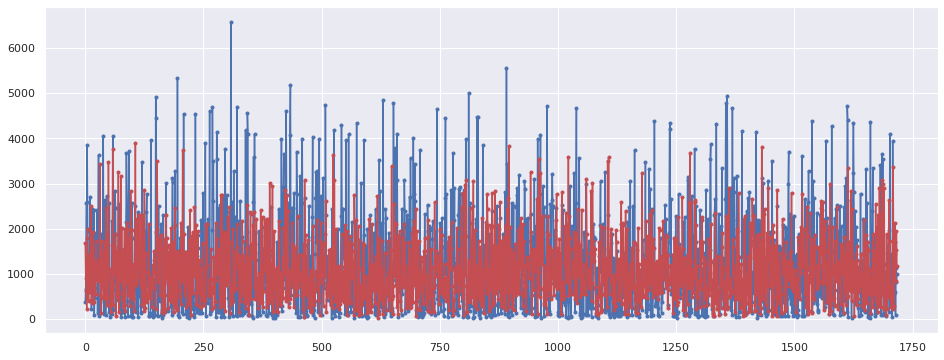

In [36]:
pred = model.predict(X_test)

y_test_inv = cnt_scaler.inverse_transform(y_test.reshape(-1,1))
pred_inv = cnt_scaler.inverse_transform(pred)

plt.figure(figsize=(16,6))
plt.plot(y_test_inv.flatten(),marker=".",label="actual")
plt.plot(pred_inv.flatten(),marker=".",label="prediction",color="r")

**Note that our model is predicting only one point in the future. That being said, it is doing very well. Although our model can’t really capture the extreme values it does a good job of predicting (understanding) the general pattern.**

In [37]:
y_test_actual = cnt_scaler.inverse_transform(y_test.reshape(-1,1))
y_test_pred = cnt_scaler.inverse_transform(pred)

arr_1 = np.array(y_test_actual)
arr_2 = np.array(y_test_pred)

actual = pd.DataFrame(data=arr_1.flatten(),columns=["actual"])
predicted = pd.DataFrame(data=arr_2.flatten(),columns = ["predicted"])

In [38]:
final = pd.concat([actual,predicted],axis=1)
final.head()

,actual,predicted
0,371.0,1678.022583
1,655.0,901.549500
2,2568.0,613.783264
3,2582.0,212.343582
4,3846.0,1792.009155


<a id='Evaluation'></a>
# **Evaluation**

In [39]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(final.actual,final.predicted)) 
r2 = r2_score(final.actual,final.predicted) 
print("rmse is : {}\nr2 is : {}".format(rmse,r2))

rmse is : 1338.5087668717797
r2 is : -0.4592762037992535


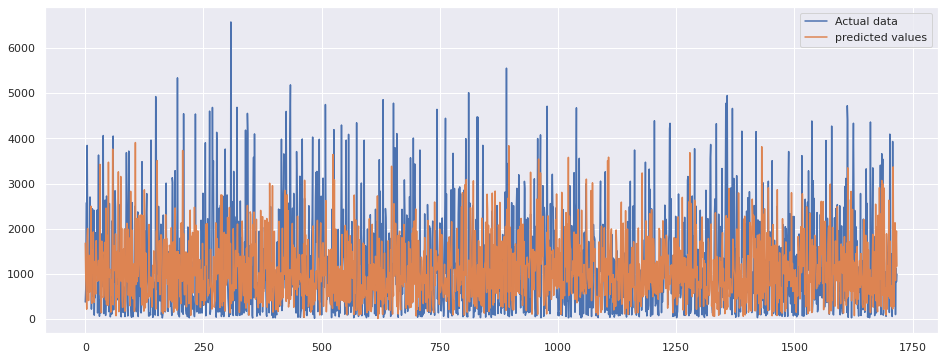

In [40]:
plt.figure(figsize=(16,6))
plt.plot(final.actual,label="Actual data")
plt.plot(final.predicted,label="predicted values")
plt.legend(loc="best")

# Conclusion : 
**AS you can see that I have used Bidirectional LSTM to train our model and Our model is working quite well.Our model is capable to capture the trend and not capturing the Extreme values which is a really good thing. SO, we can say that the overall perfomance is good.**

# If you like this notebook Please Do give an Upvote.


[](http://)